# Next-word Generator for the Sherlock Holmes dataset
 - Dataset sourced from [The Adventures of Sherlock Holmes, by Arthur Conan Doyle](https://www.gutenberg.org/files/1661/1661-0.txt)

## Imports and Initial Configuration

In [12]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import plotly.express as px  
import plotly.graph_objects as go
import re
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Set up Plotly for better visualization
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

# Display PyTorch version and set device
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directory
dataset_dir = os.path.join(os.getcwd(), 'datasets')


PyTorch Version: 2.5.0+cu124
Using device: cuda


## Text Cleaning Function

We define a function to clean the text by handling punctuation more effectively and ensuring case insensitivity.

In [13]:
import os
import re

def clean_text(filename: str):
    """
    Reads and cleans text from a file.
    Handles punctuation by separating them as distinct tokens,
    replaces single or multiple newline boundaries with <PAR_BREAK>, 
    and converts all text to lowercase.
    """
    filepath = os.path.join(dataset_dir, filename)
    with open(filepath, encoding='utf-8') as file:
        text = file.read()

    # Convert to lowercase for case insensitivity
    text = text.lower()
    
    # Separate specified punctuation by adding spaces around them
    # Punctuation marks: ., ,, !, ?, -
    text = re.sub(r'([.,!?-])', r' \1 ', text)
    
    # Remove any unwanted characters except specified punctuation and alphanumerics
    text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', ' ', text)

    # Replace any single or multiple newline characters with <PAR_BREAK>
    text = re.sub(r'\n+', ' <PAR_BREAK> ', text)
    # Remove extra spaces
    text = " ".join(text.split())
    
    return text


## Unique Words Extraction Function

Extracts unique words, including punctuation, and creates mappings between words and their indices.

In [14]:
# %%
def unique_words(text: str):
    """
    Extracts unique words and punctuation from the text.
    Creates mappings from string to index and vice versa.
    Includes special tokens for paragraph boundaries and <UNK>.
    """
    words = pd.Series(text.split())
    
    # Define allowed punctuation marks
    allowed_punctuations = {'.', ',', '!', '?', '-'}
    
    # Filter words by length and ensure they are alphanumeric or specified punctuation
    words = words[((words.str.len() > 0) & (words.str.len() < 20))]
    words = words[words.isin(allowed_punctuations) | words.str.match(r'^[a-zA-Z0-9]+$')]
    
    # Drop duplicates and sort
    words = words.drop_duplicates(ignore_index=True)
    vocab = words.sort_values().to_list()
    
    # Initialize stoi with special tokens
    special_tokens = ['<PAR_BREAK>', '<UNK>']
    stoi = {token: i + 1 for i, token in enumerate(special_tokens)}
    
    # Add the remaining vocabulary words, starting from the next available index
    next_index = len(stoi) + 1
    for word in vocab:
        if word not in stoi:
            stoi[word] = next_index
            next_index += 1
    
    # Create the itos mapping based on updated stoi
    itos = {i: s for s, i in stoi.items()}
    
    return vocab, stoi, itos


## Data Preparation
We prepare the dataset by creating input-output pairs based on a context window.

In [15]:
def prepare_data(text: str, block_size: int, stoi):
    """
    Prepares input-output pairs for training.
    Each input consists of `block_size` tokens, and the target is the next token.
    Unknown words are mapped to the <UNK> token.
    """
    words = text.split()
    X, Y = [], []
    
    # Ensure <UNK> and <PAR_BREAK> tokens are in stoi
    unk_token = '<UNK>'
    par_break_token = '<PAR_BREAK>'
    if unk_token not in stoi:
        stoi[unk_token] = len(stoi) + 1
    if par_break_token not in stoi:
        stoi[par_break_token] = len(stoi) + 1

    unk_idx = stoi[unk_token]
    par_break_idx = stoi[par_break_token]
    
    for i in range(block_size, len(words)):
        context = words[i-block_size:i]
        target = words[i]
        
        # Convert context and target to indices, map unknown words to <UNK>
        context_ix = [stoi.get(word, unk_idx) for word in context]
        target_ix = stoi.get(target, unk_idx)
        
        X.append(context_ix)
        Y.append(target_ix)
    
    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.long).to(device)
    Y = torch.tensor(Y, dtype=torch.long).to(device)
    
    return X, Y

## Data Cleaning and Preparation
We clean the text, build the vocabulary, and prepare the data for training.

In [16]:
# Clean the text from the dataset
text = clean_text('sherlock.txt')

# Extract unique words and create mappings
vocab, stoi, itos = unique_words(text)

# Add the <UNK> and <PAR_BREAK> tokens to `stoi` and `itos` if not present
if '<UNK>' not in stoi:
    unk_idx = len(stoi)
    stoi['<UNK>'] = unk_idx
    itos[unk_idx] = '<UNK>'

if '<PAR_BREAK>' not in stoi:
    par_break_idx = len(stoi)
    stoi['<PAR_BREAK>'] = par_break_idx
    itos[par_break_idx] = '<PAR_BREAK>'

# Prepare input-output pairs with a context window of 5
block_size = 5
X, Y = prepare_data(text, block_size, stoi)

# Display the shapes of the tensors
print(f"Input shape: {X.shape}, dtype: {X.dtype}")
print(f"Target shape: {Y.shape}, dtype: {Y.dtype}")


Input shape: torch.Size([134848, 5]), dtype: torch.int64
Target shape: torch.Size([134848]), dtype: torch.int64


In [17]:
with open("stoi_sherlock.json", "w") as f:
    json.dump(stoi, f)

with open("itos_sherlock.json", "w") as f:
    json.dump(itos, f)

In [6]:
# %%
# Number of samples to display
num_samples = 20

print(f"Displaying {num_samples} sample input-output pairs:\n")

# Iterate over the first num_samples and print context and target
for i in range(num_samples):
    # Get context indices and target index
    context_indices = X[i].tolist()
    target_index = Y[i].item()
    
    # Convert indices back to words, using <UNK> for unknown indices
    context_words = [itos.get(idx, '<UNK>') for idx in context_indices]
    target_word = itos.get(target_index, '<UNK>')
    
    # Print the context and target
    print(f"--- Sample {i+1} ---")
    print(f"Context: {' '.join(context_words)}")
    print(f"Target: {target_word}\n")


Displaying 20 sample input-output pairs:

--- Sample 1 ---
Context: the project gutenberg ebook of
Target: the

--- Sample 2 ---
Context: project gutenberg ebook of the
Target: adventures

--- Sample 3 ---
Context: gutenberg ebook of the adventures
Target: of

--- Sample 4 ---
Context: ebook of the adventures of
Target: sherlock

--- Sample 5 ---
Context: of the adventures of sherlock
Target: holmes

--- Sample 6 ---
Context: the adventures of sherlock holmes
Target: ,

--- Sample 7 ---
Context: adventures of sherlock holmes ,
Target: <PAR_BREAK>

--- Sample 8 ---
Context: of sherlock holmes , <PAR_BREAK>
Target: by

--- Sample 9 ---
Context: sherlock holmes , <PAR_BREAK> by
Target: arthur

--- Sample 10 ---
Context: holmes , <PAR_BREAK> by arthur
Target: conan

--- Sample 11 ---
Context: , <PAR_BREAK> by arthur conan
Target: doyle

--- Sample 12 ---
Context: <PAR_BREAK> by arthur conan doyle
Target: <PAR_BREAK>

--- Sample 13 ---
Context: by arthur conan doyle <PAR_BREAK>
Target: this

## Embedding Initialization and Visualization

We initialize the embedding layer and visualize the embeddings using t-SNE with Plotly.

In [7]:
# %%
# Define hyperparameters
embedding_dim = 256  # Increased embedding size

# Initialize the embedding layer
embedding = nn.Embedding(len(stoi) + 1, embedding_dim).to(device)  # +1 for padding if needed
print(f"Embedding Weights Shape: {embedding.weight.shape}")

# Convert embeddings to NumPy for visualization
embeddings = embedding.weight.detach().cpu().numpy()

# Perform t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame for Plotly
words = list(stoi.keys())
df = pd.DataFrame({
    'word': words,
    'x': embeddings_2d[:len(words), 0],
    'y': embeddings_2d[:len(words), 1]
})

# Plot using Plotly Express
fig = px.scatter(
    df, 
    x='x', 
    y='y', 
    hover_name='word',  # Display word only on hover
    title='t-SNE Visualization of Word Embeddings',
    width=800,
    height=800
)

# Customize the plot to hide text labels and show only dots
fig.update_traces(
    marker=dict(size=5, color='blue'),  # Customize dot color and size
    hovertemplate='<b>%{hovertext}</b><extra></extra>'  # Show only the word on hover
)
fig.update_layout(
    title=dict(x=0.5),
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template='plotly_white'
)

fig.show()

Embedding Weights Shape: torch.Size([8158, 256])


## MLP for next word prediction
We define the neural network model with an increased hidden layer size.

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameters
hidden_dim = 512
epochs = 100
learning_rate = 0.001
batch_size = 2048  # Define the batch size for mini-batch gradient descent

# Define the model
class NextWord(nn.Module):
    """
    A feedforward neural network with multiple hidden layers for next-word prediction.
    Utilizes Leaky ReLU activation functions to improve gradient flow.
    """
    def __init__(self, block_size, vocab_size, embedding_dim, hidden_dim):
        super(NextWord, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lin1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)
        
        out = self.leaky_relu(self.lin1(embeds))
        out = self.leaky_relu(self.lin2(out))
        out = self.leaky_relu(self.lin3(out))
        out = self.leaky_relu(self.lin4(out))
        
        return self.lin_out(out)

# Initialize the model
model = NextWord(block_size, len(stoi) + 1, embedding_dim, hidden_dim).to(device)

# Prepare DataLoader for mini-batch gradient descent
def create_data_loader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Assuming X, Y are tensors prepared by the prepare_data function
data_loader = create_data_loader(X, Y, batch_size)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [9]:
for param_name, param in model.named_parameters():
    print(f"{param_name}: {param.shape}")

embedding.weight: torch.Size([8158, 256])
lin1.weight: torch.Size([512, 1280])
lin1.bias: torch.Size([512])
lin2.weight: torch.Size([512, 512])
lin2.bias: torch.Size([512])
lin3.weight: torch.Size([512, 512])
lin3.bias: torch.Size([512])
lin4.weight: torch.Size([512, 512])
lin4.bias: torch.Size([512])
lin_out.weight: torch.Size([8158, 512])
lin_out.bias: torch.Size([8158])


## Training Loop

Epoch 1/100, Loss: 6.1913


Epoch 5/100, Loss: 4.3982
Epoch 10/100, Loss: 2.8990
Epoch 15/100, Loss: 1.4194
Epoch 20/100, Loss: 0.6101
Epoch 25/100, Loss: 0.3074
Epoch 30/100, Loss: 0.1929
Epoch 35/100, Loss: 0.1678
Epoch 40/100, Loss: 0.1694
Epoch 45/100, Loss: 0.1608
Epoch 50/100, Loss: 0.1123
Epoch 55/100, Loss: 0.0809
Epoch 60/100, Loss: 0.0696
Epoch 65/100, Loss: 0.0674
Epoch 70/100, Loss: 0.5290
Epoch 75/100, Loss: 0.0832
Epoch 80/100, Loss: 0.0612
Epoch 85/100, Loss: 0.0561
Epoch 90/100, Loss: 0.0553
Epoch 95/100, Loss: 0.0532
Epoch 100/100, Loss: 0.5137


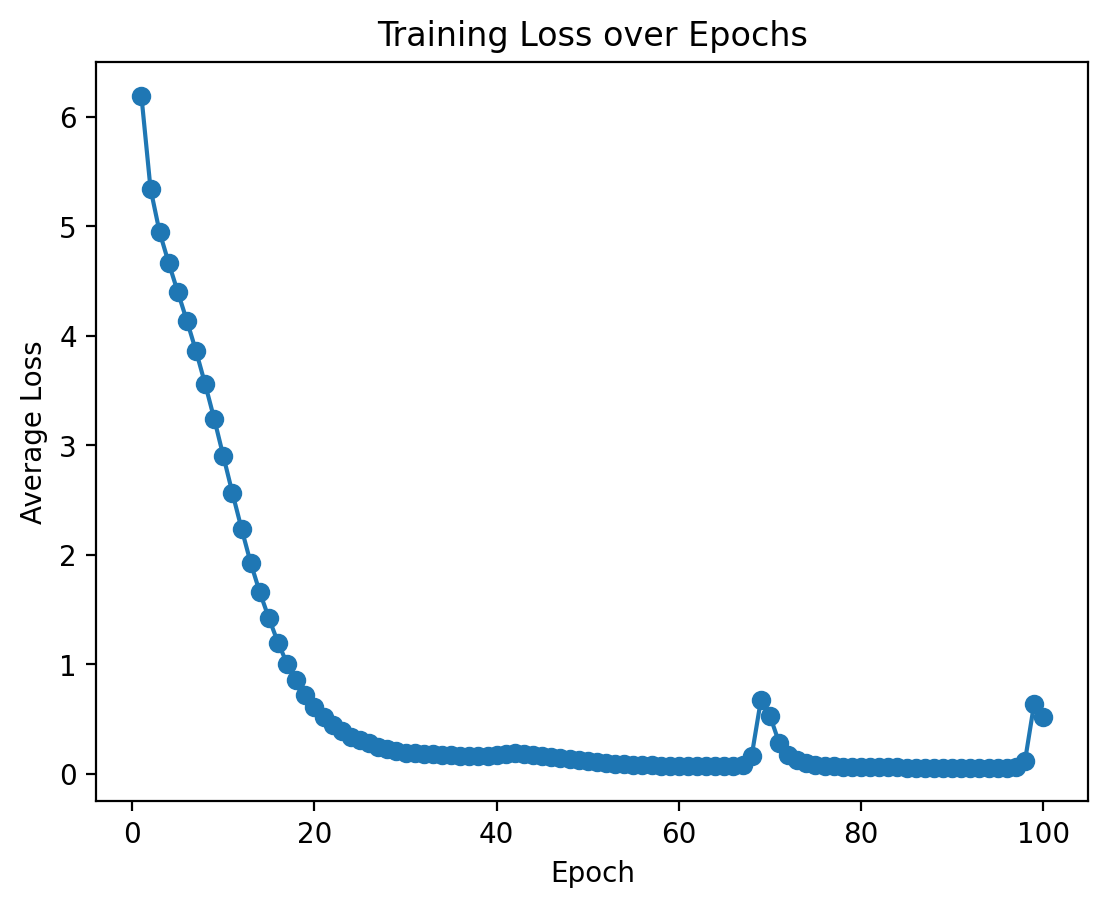

In [10]:
import matplotlib.pyplot as plt

# List to store the average loss for each epoch
loss_history = []

# Training loop with mini-batch gradient descent
for epoch in range(1, epochs + 1):
    model.train()  # Set model to training mode
    total_loss = 0  # Track total loss for the epoch
    
    for batch_X, batch_Y in data_loader:
        # Move batches to device
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_Y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Average loss per epoch
    avg_loss = total_loss / len(data_loader)
    loss_history.append(avg_loss)  # Store the average loss

    # Print progress every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# Plot the loss history
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.show()


## Saving the model

In [11]:
# Save the model after training
model_save_path = 'models/sherlock_nextword_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/sherlock_nextword_model.pth


## Loading the saved model (if not training from scratch)

In [12]:
# model = NextWord(block_size, vocab_size, embedding_dim, hidden_dim).to(device)
# model.load_state_dict(torch.load(model_save_path))
# model.eval()  # Set to evaluation mode if not training further

## generate_sequence function

The `generate_sequence` function performs the following steps:

1. **Context Preparation**:
   - Converts the provided `context_words` to indices using `stoi`, with unknown words mapped to `<UNK>`.

2. **Generate Words in Sequence**:
   - Iteratively generates words up to the `max_len` limit:
      - **Prepares Input Tensor**: Converts the latest context window to a tensor for model input.
      - **Predicts Next Word**: Passes the tensor through the model, applies softmax, and samples a word from the output distribution.
      - **Handles Punctuation and Capitalization**: Checks if the generated word is punctuation. If it is a period, sets a flag to capitalize the next word.
      - **Appends Generated Word**: Adds the generated word to the sequence and updates the context.

3. **Post-processing**:
   - Joins the generated sequence into a single string.
   - Removes spaces before punctuation marks (e.g., periods, commas) to improve readability.

In [13]:

def generate_sequence(model, itos, stoi, context_words, block_size, max_len=20):
    model.eval()  # Set model to evaluation mode
    unk_idx = stoi.get('<UNK>', 0)  # Get index for unknown words, default to 0 if <UNK> not found
    
    # Convert context words to indices, map unknown words to <UNK>
    context = [stoi.get(word, unk_idx) for word in context_words]
    
    # Pad context if it's shorter than block_size
    if len(context) < block_size:
        pad_idx = stoi.get('<UNK>', unk_idx)  # Use <UNK> for padding if available
        context = [pad_idx] * (block_size - len(context)) + context
    
    sequence = context_words.copy()
    capitalize_next = False  # Flag to determine if the next word should be capitalized
    
    # If the last word in context ends with a period, set the flag
    if sequence and sequence[-1].endswith('.'):
        capitalize_next = True
    
    with torch.no_grad():
        for _ in range(max_len):
            # Prepare input tensor
            x = torch.tensor(context[-block_size:], dtype=torch.long).unsqueeze(0).to(device)  # Shape: [1, block_size]
            
            # Get model predictions
            y_pred = model(x)  # [1, vocab_size]
            
            # Apply softmax to get probabilities
            probs = F.softmax(y_pred, dim=1)
            
            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            word = itos.get(ix, '<UNK>')
            
            # Determine if the word is punctuation
            is_punct = word in {'.', ',', '!', '?'}
            
            # Capitalize the word if the flag is set and it's not punctuation
            if capitalize_next and not is_punct and word != '<PAR_BREAK>':
                word = word.capitalize()
                capitalize_next = False  # Reset the flag after capitalizing
            
            # Handle paragraph breaks
            if word == '<PAR_BREAK>':
                sequence.append('\n')  # Add a newline to represent the paragraph break
                capitalize_next = True  # Capitalize the first word after a paragraph break
            else:
                # Append the generated word to the sequence
                sequence.append(word)
            
            # Update the context with the generated word's index
            context.append(ix)
            
            # If the generated word is a period, set the flag to capitalize the next word
            if word.endswith('.'):
                capitalize_next = True
    
    # Post-processing to remove spaces before punctuation marks
    generated_text = ' '.join(sequence)
    # Remove space before punctuation marks
    generated_text = re.sub(r'\s+([.,!?])', r'\1', generated_text)
    
    return generated_text


In [14]:
sherlock_contexts = [
    "The mysterious case was seemingly",
    "A peculiar",
    "Evidence",
    "The silent witness",
    "An unexpected clue",
    "A shadowy figure crept upon",
    "The hidden truth was",
    "In the dimly lit room",
    "A cryptic message",
    "The final deduction was made "
]

# Iterate over each context and generate sequences
for idx, context in enumerate(sherlock_contexts, 1):
    # Generate a sequence of 20 words based on the context
    generated_sequence = generate_sequence(
        model=model,
        itos=itos,
        stoi=stoi,
        context_words=context.split(),
        block_size=block_size,
        max_len=60
    )
    
    # Print the results
    print(f"--- Sequence {idx} ---")
    print(f"Context: {context}")
    print(f"Generated sequence: {generated_sequence}\n")

--- Sequence 1 ---
Context: The mysterious case was seemingly
Generated sequence: The mysterious case was seemingly, or 
 Quite help up in his cases which 
 Would bring them when a letter of his pink girl, like a little, in the middle - master. 
 When did it solid all those, and with the slight chance, until an last very 
 Not. If a turn while 
 And capable

--- Sequence 2 ---
Context: A peculiar
Generated sequence: A peculiar 
 Master. I had not hysterical 
 Her evening. 
 We have had the pleasure of making the doctor s acquaintance, said holmes, as a tall dog - cart into the crown 
 Which i have just it. I am mr. St. Clair had it not been yet, shortly hard by one

--- Sequence 3 ---
Context: Evidence
Generated sequence: Evidence. Your majesty has been waiting from two with covent 
 Hotel. It is certain that you have hit 
 Place, my dear name, 
 And too, with a stare, 
 And a indeed, as i expected, lounging his eyes 
 Into the back - stains and close into the water - house

--- Sequen

## t-SNE Visualization of Trained Embeddings
Finally, we visualize the trained word embeddings using t-SNE with Plotly.

In [15]:
# %%
# Extract trained embeddings
trained_embeddings = model.embedding.weight.detach().cpu().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
trained_embeddings_2d = tsne.fit_transform(trained_embeddings)

# Create DataFrame for Plotly
trained_df = pd.DataFrame({
    'word': list(stoi.keys()),
    'x': trained_embeddings_2d[:len(stoi), 0],
    'y': trained_embeddings_2d[:len(stoi), 1]
})

# Plot using Plotly Express without displaying word labels
fig = px.scatter(
    trained_df, 
    x='x', 
    y='y', 
    # Remove the 'text' parameter to hide word labels
    title='t-SNE Visualization of Trained Word Embeddings',
    hover_name='word',  # Set the word to appear on hover
    hover_data={'x': False, 'y': False},  # Exclude x and y from hover
    width=800,
    height=800
)

# Customize the plot by removing text-related trace settings
fig.update_traces(
    marker=dict(size=5)
    # Removed textposition and textfont since text labels are not displayed
)
fig.update_layout(
    title=dict(x=0.5),
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template='plotly_white'
)

fig.show()


## t-SNE plot in 3D

In [16]:
# %%
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import torch
import re

# Ensure that 'stoi' and 'itos' are defined
if 'stoi' not in globals() or 'itos' not in globals():
    raise NameError("'stoi' and/or 'itos' are not defined. Please run the data preparation cells first.")

# Verify that the model has an embedding layer
if not hasattr(model, 'embedding'):
    raise AttributeError("The model does not have an 'embedding' attribute.")

# Extract trained embeddings from the model
trained_embeddings = model.embedding.weight.detach().cpu().numpy()
print(f"Shape of trained_embeddings: {trained_embeddings.shape}")
print(f"Number of words in 'stoi': {len(stoi)}")

# Assuming index 0 is reserved for padding, exclude it
# Ensure that trained_embeddings has len(stoi) + 1 embeddings
expected_embeddings = len(stoi) + 1  # +1 for padding
actual_embeddings = trained_embeddings.shape[0]

if actual_embeddings != expected_embeddings:
    raise ValueError(f"Mismatch between embeddings ({actual_embeddings}) and vocabulary size + padding ({expected_embeddings}).")

# Perform t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
trained_embeddings_3d = tsne.fit_transform(trained_embeddings)

# Create a DataFrame for Plotly
# Exclude the first embedding (index 0) which is for padding
words = list(stoi.keys())
if actual_embeddings - 1 != len(words):
    raise ValueError(f"After excluding padding, number of words ({len(words)}) does not match embeddings ({actual_embeddings - 1}).")

df = pd.DataFrame({
    'word': words,
    'x': trained_embeddings_3d[1:, 0],  # Skip index 0
    'y': trained_embeddings_3d[1:, 1],
    'z': trained_embeddings_3d[1:, 2]
})

# Plot in 3D using Plotly Express
fig = px.scatter_3d(
    df, 
    x='x', 
    y='y', 
    z='z', 
    hover_name='word',  # Show word on hover
    hover_data={'x': False, 'y': False, 'z': False},  # Hide coordinates on hover
    title='3D t-SNE Visualization of Trained Word Embeddings',
    width=800,
    height=800
)

# Customize the plot
fig.update_traces(
    marker=dict(size=5, color='blue', opacity=0.7)
)
fig.update_layout(
    title=dict(x=0.5, y=0.95, xanchor='center', yanchor='top'),
    scene=dict(
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        zaxis_title="t-SNE Dimension 3"
    ),
    template='plotly_white'
)

fig.show()


Shape of trained_embeddings: (8158, 256)
Number of words in 'stoi': 8157
